<a href="https://colab.research.google.com/github/sur-sakthy/computer-vision/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #1
The provided data has a train/validation split of 1000/500 (approx.) images. In this task you are to select any 4 classes from the original ImageNette data as your working dataset (i.e. classification whereby you are predicting one of four possible classes).

Additionally, you need to reorganise the data into appropriate train/validation/test split before you train your network models. The details of the splitting is left to you, but you must fully justify any final split used in your evaluation.

In [1]:
!nvidia-smi

Fri Mar 17 22:49:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!cp '/content/drive/MyDrive/EE544 Computer Vision/imagenette2-160.tgz' ./

In [3]:
# remove %%capture command to show output from unzipping
%%capture 
!tar zxvf /content/imagenette2-160.tgz

## Imports

In [4]:
import os
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, AUC, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

## Constants

In [5]:
PATH_TO_TRAIN_DATA = '/content/imagenette2-160/train'
PATH_TO_VAL_DATA = '/content/imagenette2-160/val'
IMG_WIDTH=64
IMG_HEIGHT=64
NUM_CLASSES=4

In [6]:
all_classes = os.listdir(PATH_TO_TRAIN_DATA)
all_classes

['n03888257',
 'n02979186',
 'n02102040',
 '.DS_Store',
 'n03417042',
 'n03028079',
 'n03000684',
 'n03394916',
 'n03425413',
 'n01440764',
 'n03445777']

In [7]:
all_classes = os.listdir(PATH_TO_VAL_DATA)
all_classes

['n03888257',
 'n02979186',
 'n02102040',
 'n03417042',
 'n03028079',
 'n03000684',
 'n03394916',
 'n03425413',
 'n01440764',
 'n03445777']

## Load dataset

In [8]:
data = []
labels = []

In [9]:
def load_dataset(img_folder): 
    for dir in os.listdir(img_folder):
      if dir == 'n03445777' or dir == 'n03417042' or dir == 'n02979186' or dir == 'n03028079' :
        for file in os.listdir(os.path.join(img_folder, dir)):
            image_path = os.path.join(img_folder, dir, file)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(64,64))
            input_arr = tf.keras.preprocessing.image.img_to_array(image)
            input_arr = np.array([input_arr])
            image = np.array(image)
            data.append(image)
            labels.append(dir)

In [10]:
load_dataset(PATH_TO_TRAIN_DATA)
load_dataset(PATH_TO_VAL_DATA)

In [11]:
np.unique(labels)

array(['n02979186', 'n03028079', 'n03417042', 'n03445777'], dtype='<U9')

In [12]:
data[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

## Shuffle and split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

## Class distribution

In [14]:
df_train = pd.DataFrame(y_train, columns=['label'])
df_train.head()

,label
0,n03028079
1,n02979186
2,n02979186
3,n03028079
4,n03445777


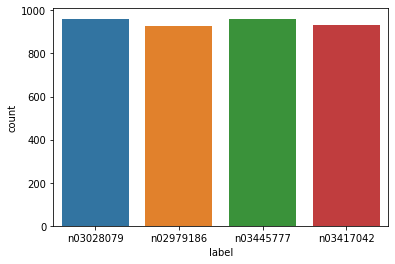

In [15]:
sns.countplot(data=df_train, x='label')
plt.show()

In [16]:
df_test = pd.DataFrame(y_test, columns=['label'])
df_test.head()

,label
0,n03028079
1,n03445777
2,n03028079
3,n03028079
4,n03028079


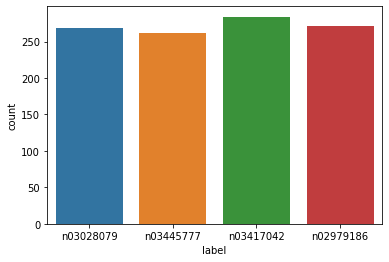

In [17]:
sns.countplot(data=df_test, x='label')
plt.show()

In [18]:
df_val = pd.DataFrame(y_val, columns=['label'])
df_val.head()

,label
0,n03028079
1,n02979186
2,n03417042
3,n03417042
4,n02979186


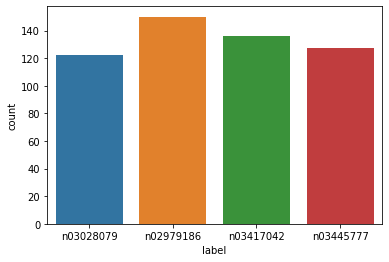

In [19]:
sns.countplot(data=df_val, x='label')
plt.show()

## Encoding

In [20]:
def one_hot_encode(y, num_classes):
  le = LabelEncoder()
  return to_categorical(le.fit_transform(y), num_classes)

In [21]:
y_train[0]

'n03028079'

In [22]:
y_train = one_hot_encode(y_train, NUM_CLASSES)

In [23]:
y_train[0]

array([0., 1., 0., 0.], dtype=float32)

In [24]:
y_test[0]

'n03028079'

In [25]:
y_test = one_hot_encode(y_test, NUM_CLASSES)

In [26]:
y_test[0]

array([0., 1., 0., 0.], dtype=float32)

In [27]:
np.array(y_train).shape

(3780, 4)

In [28]:
y_val[0]

'n03028079'

In [29]:
y_val = one_hot_encode(y_val, NUM_CLASSES)

In [30]:
y_val

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

## Create train, validation and test sets

In [31]:
train_datagen = ImageDataGenerator(        
        rescale=1./255,
        fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [32]:
train_ds = train_datagen.flow(
  np.array(X_train), y_train,
  shuffle=True,
  batch_size=128
)

val_ds = train_datagen.flow(
  np.array(X_val), y_val,
  shuffle=True,
  batch_size=128
)

test_ds = test_datagen.flow(
  np.array(X_test), y_test,
  shuffle=False,
  batch_size=128
)

In [33]:
print('Shape of training samples: ', train_ds.x.shape)
print('Shape of validation samples: ', val_ds.x.shape)
print('Shape of test samples: ', test_ds.x.shape)

Shape of training samples:  (3780, 64, 64, 3)
Shape of validation samples:  (535, 64, 64, 3)
Shape of test samples:  (1085, 64, 64, 3)


## Build model

In [34]:
def build_model(batchNorm=False, dropOut=False, l2Reg=False):
  model = Sequential()

  if l2Reg:
    model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer='l2', input_shape=(64,64,3)))
    model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer='l2'))
  else:
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(64,64,3)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
  
  model.add(MaxPooling2D(pool_size=(2,2)))

  if batchNorm:
    model.add(BatchNormalization())

  if l2Reg:
    model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_regularizer='l2'))
    model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_regularizer='l2'))
  else:
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
  
  model.add(MaxPooling2D(pool_size=(2,2)))

  if batchNorm:
    model.add(BatchNormalization())

  model.add(Flatten())

  if l2Reg:
    model.add(Dense(512, kernel_regularizer='l2'))
  else:
    model.add(Dense(512))
  
  if dropOut:
    model.add(Dropout(0.25))

  if l2Reg:
    model.add(Dense(NUM_CLASSES, activation='softmax', kernel_regularizer='l2'))
  else:
    model.add(Dense(NUM_CLASSES, activation='softmax'))

  model.compile(
      optimizer=Adam(),
      loss='categorical_crossentropy',
      metrics=[
          CategoricalAccuracy(),
          Precision(), 
          Recall(),
          AUC()
        ]
  )

  return model

In [35]:
baseline_model = build_model()
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                    

## Train model

### Initialise callbacks

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=20)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/EE544 Computer Vision/task-1-weights.hdf5', verbose=1, save_best_only=True, monitor='val_categorical_accuracy')

### Fit the model

In [37]:
baseline_history = baseline_model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds,
    callbacks=[checkpoint]
)

Epoch 1/30
29/30 [============================>.] - ETA: 0s - loss: 1.3582 - categorical_accuracy: 0.4184 - precision: 0.5486 - recall: 0.1112 - auc: 0.6713
Epoch 1: val_categorical_accuracy improved from -inf to 0.61682, saving model to /content/drive/MyDrive/EE544 Computer Vision/task-1-weights.hdf5
30/30 [==============================] - 10s 70ms/step - loss: 1.3509 - categorical_accuracy: 0.4209 - precision: 0.5561 - recall: 0.1193 - auc: 0.6744 - val_loss: 0.9809 - val_categorical_accuracy: 0.6168 - val_precision: 0.7624 - val_recall: 0.4019 - val_auc: 0.8396
Epoch 2/30
30/30 [==============================] - ETA: 0s - loss: 0.9598 - categorical_accuracy: 0.6185 - precision: 0.7073 - recall: 0.4640 - auc: 0.8410
Epoch 2: val_categorical_accuracy improved from 0.61682 to 0.68037, saving model to /content/drive/MyDrive/EE544 Computer Vision/task-1-weights.hdf5
30/30 [==============================] - 1s 43ms/step - loss: 0.9598 - categorical_accuracy: 0.6185 - precision: 0.7073 - 

## Plot results

In [38]:
def plot(train, validation, ylabel, title):
  plt.plot(train, color='red', label='train') 
  plt.plot(validation, color='blue', label='validation') 
  plt.title(title) 
  plt.ylabel(ylabel)
  plt.xlabel('Epoch')
  plt.legend() 
  plt.grid(linestyle='-', linewidth=0.5)

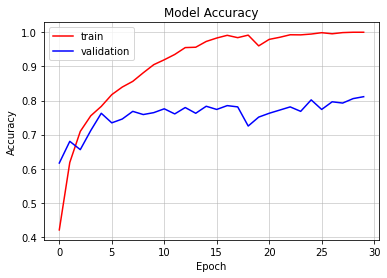

In [39]:
plot(baseline_history.history['categorical_accuracy'], baseline_history.history['val_categorical_accuracy'], 'Accuracy', 'Model Accuracy')

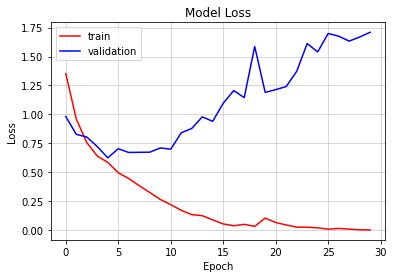

In [40]:
plot(baseline_history.history['loss'], baseline_history.history['val_loss'], 'Loss', 'Model Loss')

## Evaluate model

In [41]:
def evaluate_and_predict(model): 
  # evaluate on test dataset
  eval_results = model.evaluate(test_ds, batch_size=30)

  # print evaluation results
  print('Test loss:', eval_results[0])
  print('Test categorical_accuracy:', eval_results[1])
  print('Test precision:', eval_results[2])
  print('Test recall:', eval_results[3])
  print('Test auc:', eval_results[4])

  # predict
  return model.predict(test_ds)

In [42]:
pred = evaluate_and_predict(baseline_model)

9/9 [==============================] - 0s 28ms/step - loss: 1.8292 - categorical_accuracy: 0.7668 - precision: 0.7673 - recall: 0.7659 - auc: 0.8960
Test loss: 1.8292030096054077
Test categorical_accuracy: 0.7668202519416809
Test precision: 0.7673130035400391
Test recall: 0.7658986449241638
Test auc: 0.8960068821907043
9/9 [==============================] - 0s 12ms/step


In [43]:
pred

array([[1.15345726e-10, 1.00000000e+00, 7.97177657e-10, 8.92113206e-12],
       [1.84909695e-05, 6.53414708e-03, 4.31919284e-03, 9.89128172e-01],
       [1.35429819e-14, 9.99991536e-01, 2.62644039e-06, 5.81227778e-06],
       ...,
       [7.41837312e-07, 2.23420826e-12, 9.99621391e-01, 3.77855176e-04],
       [7.25813732e-02, 4.75287350e-04, 9.25566494e-01, 1.37689861e-03],
       [5.87503845e-03, 4.68964208e-11, 2.18266594e-12, 9.94124949e-01]],
      dtype=float32)

In [44]:
def draw_confusion_matrix(true, pred):
  cm = confusion_matrix(true.argmax(axis=1), pred.argmax(axis=1))
  sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='g', cbar=False, cmap="viridis")
  plt.show()

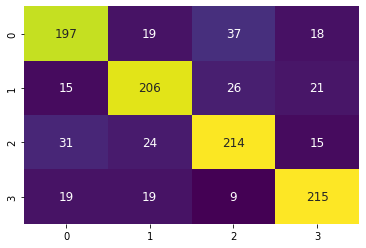

In [45]:
draw_confusion_matrix(y_test, pred)

In [46]:
print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       271
           1       0.77      0.77      0.77       268
           2       0.75      0.75      0.75       284
           3       0.80      0.82      0.81       262

    accuracy                           0.77      1085
   macro avg       0.77      0.77      0.77      1085
weighted avg       0.77      0.77      0.77      1085



## Improve the baseline networks performance
1. Batch Normalisation 
2. Dropout 
3. Regularisation

### Batch Normalisation

In [47]:
batchnorm_model = build_model(batchNorm=True)
batchnorm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 64)       

In [48]:
batchnorm_history = batchnorm_model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
30/30 [==============================] - 6s 52ms/step - loss: 5.5439 - categorical_accuracy: 0.6048 - precision_1: 0.6084 - recall_1: 0.6021 - auc_1: 0.7828 - val_loss: 1.4360 - val_categorical_accuracy: 0.2467 - val_precision_1: 0.3445 - val_recall_1: 0.1533 - val_auc_1: 0.5935
Epoch 2/30
30/30 [==============================] - 1s 36ms/step - loss: 1.9238 - categorical_accuracy: 0.7574 - precision_1: 0.7605 - recall_1: 0.7561 - auc_1: 0.8918 - val_loss: 2.2701 - val_categorical_accuracy: 0.2598 - val_precision_1: 0.2714 - val_recall_1: 0.2374 - val_auc_1: 0.5283
Epoch 3/30
30/30 [==============================] - 1s 36ms/step - loss: 0.5392 - categorical_accuracy: 0.8772 - precision_1: 0.8806 - recall_1: 0.8757 - auc_1: 0.9682 - val_loss: 1.5300 - val_categorical_accuracy: 0.2449 - val_precision_1: 0.2818 - val_recall_1: 0.2112 - val_auc_1: 0.5986
Epoch 4/30
30/30 [==============================] - 1s 36ms/step - loss: 0.1751 - categorical_accuracy: 0.9460 - precision_1: 0

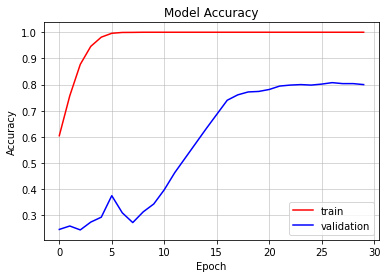

In [49]:
plot(batchnorm_history.history['categorical_accuracy'], batchnorm_history.history['val_categorical_accuracy'], 'Accuracy', 'Model Accuracy')

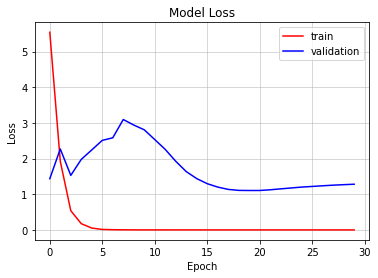

In [50]:
plot(batchnorm_history.history['loss'], batchnorm_history.history['val_loss'], 'Loss', 'Model Loss')

In [51]:
batchnorm_pred = evaluate_and_predict(batchnorm_model)

9/9 [==============================] - 0s 20ms/step - loss: 1.4401 - categorical_accuracy: 0.7594 - precision_1: 0.7642 - recall_1: 0.7585 - auc_1: 0.9101
Test loss: 1.4401063919067383
Test categorical_accuracy: 0.7594469785690308
Test precision: 0.7641596794128418
Test recall: 0.7585253715515137
Test auc: 0.9101407527923584
9/9 [==============================] - 0s 17ms/step


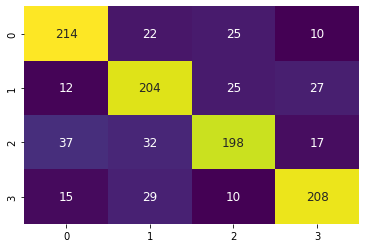

In [52]:
draw_confusion_matrix(y_test, batchnorm_pred)

In [53]:
print(classification_report(y_test.argmax(axis=1), batchnorm_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       271
           1       0.71      0.76      0.74       268
           2       0.77      0.70      0.73       284
           3       0.79      0.79      0.79       262

    accuracy                           0.76      1085
   macro avg       0.76      0.76      0.76      1085
weighted avg       0.76      0.76      0.76      1085



### Dropout

In [54]:
dropout_model = build_model(dropOut=True)
dropout_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                  

In [55]:
dropout_history = dropout_model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
30/30 [==============================] - 4s 49ms/step - loss: 1.4369 - categorical_accuracy: 0.3328 - precision_2: 0.3084 - recall_2: 0.0283 - auc_2: 0.5982 - val_loss: 1.2050 - val_categorical_accuracy: 0.3963 - val_precision_2: 0.5442 - val_recall_2: 0.2187 - val_auc_2: 0.7333
Epoch 2/30
30/30 [==============================] - 1s 35ms/step - loss: 0.9533 - categorical_accuracy: 0.6042 - precision_2: 0.7151 - recall_2: 0.4116 - auc_2: 0.8440 - val_loss: 0.8418 - val_categorical_accuracy: 0.6486 - val_precision_2: 0.7221 - val_recall_2: 0.5682 - val_auc_2: 0.8789
Epoch 3/30
30/30 [==============================] - 1s 35ms/step - loss: 0.7769 - categorical_accuracy: 0.6944 - precision_2: 0.7632 - recall_2: 0.6114 - auc_2: 0.8967 - val_loss: 0.6867 - val_categorical_accuracy: 0.7551 - val_precision_2: 0.8101 - val_recall_2: 0.6617 - val_auc_2: 0.9213
Epoch 4/30
30/30 [==============================] - 1s 35ms/step - loss: 0.6647 - categorical_accuracy: 0.7376 - precision_2: 0

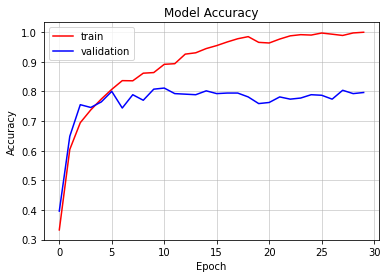

In [56]:
plot(dropout_history.history['categorical_accuracy'], dropout_history.history['val_categorical_accuracy'], 'Accuracy', 'Model Accuracy')

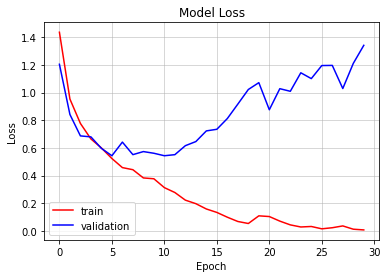

In [57]:
plot(dropout_history.history['loss'], dropout_history.history['val_loss'], 'Loss', 'Model Loss')

In [58]:
dropout_pred = evaluate_and_predict(dropout_model)

9/9 [==============================] - 0s 15ms/step - loss: 1.4574 - categorical_accuracy: 0.7899 - precision_2: 0.7920 - recall_2: 0.7862 - auc_2: 0.9135
Test loss: 1.4574482440948486
Test categorical_accuracy: 0.7898617386817932
Test precision: 0.7920148372650146
Test recall: 0.7861751317977905
Test auc: 0.9134795069694519
9/9 [==============================] - 0s 11ms/step


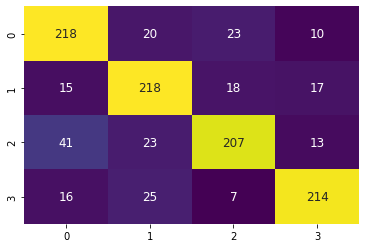

In [59]:
draw_confusion_matrix(y_test, dropout_pred)

In [60]:
print(classification_report(y_test.argmax(axis=1), dropout_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.75      0.80      0.78       271
           1       0.76      0.81      0.79       268
           2       0.81      0.73      0.77       284
           3       0.84      0.82      0.83       262

    accuracy                           0.79      1085
   macro avg       0.79      0.79      0.79      1085
weighted avg       0.79      0.79      0.79      1085



### L2 Regularisation

In [61]:
l2reg_model = build_model(l2Reg=True)
l2reg_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                  

In [62]:
l2reg_history = l2reg_model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
30/30 [==============================] - 4s 50ms/step - loss: 6.5096 - categorical_accuracy: 0.3653 - precision_3: 0.4312 - recall_3: 0.0812 - auc_3: 0.6271 - val_loss: 3.2749 - val_categorical_accuracy: 0.5215 - val_precision_3: 0.6667 - val_recall_3: 0.2505 - val_auc_3: 0.7646
Epoch 2/30
30/30 [==============================] - 1s 35ms/step - loss: 2.4940 - categorical_accuracy: 0.5550 - precision_3: 0.6876 - recall_3: 0.3190 - auc_3: 0.8058 - val_loss: 1.9111 - val_categorical_accuracy: 0.6075 - val_precision_3: 0.6800 - val_recall_3: 0.4766 - val_auc_3: 0.8460
Epoch 3/30
30/30 [==============================] - 1s 35ms/step - loss: 1.7065 - categorical_accuracy: 0.6368 - precision_3: 0.7171 - recall_3: 0.4876 - auc_3: 0.8566 - val_loss: 1.6210 - val_categorical_accuracy: 0.6243 - val_precision_3: 0.7531 - val_recall_3: 0.4505 - val_auc_3: 0.8478
Epoch 4/30
30/30 [==============================] - 1s 36ms/step - loss: 1.4945 - categorical_accuracy: 0.6532 - precision_3: 0

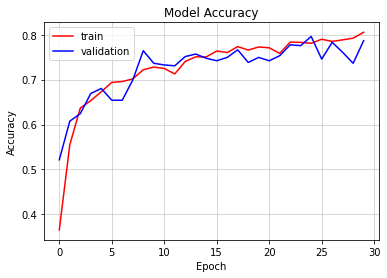

In [63]:
plot(l2reg_history.history['categorical_accuracy'], l2reg_history.history['val_categorical_accuracy'], 'Accuracy', 'Model Accuracy')

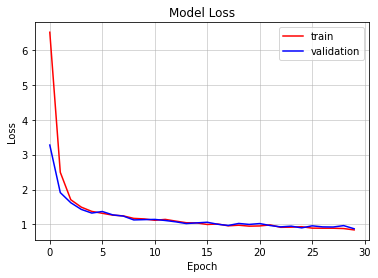

In [64]:
plot(l2reg_history.history['loss'], l2reg_history.history['val_loss'], 'Loss', 'Model Loss')

In [65]:
l2reg_pred = evaluate_and_predict(l2reg_model)

9/9 [==============================] - 0s 14ms/step - loss: 0.9641 - categorical_accuracy: 0.7401 - precision_3: 0.7983 - recall_3: 0.6931 - auc_3: 0.9288
Test loss: 0.9640672206878662
Test categorical_accuracy: 0.7400921583175659
Test precision: 0.7983014583587646
Test recall: 0.6930875778198242
Test auc: 0.9287766814231873
9/9 [==============================] - 0s 12ms/step


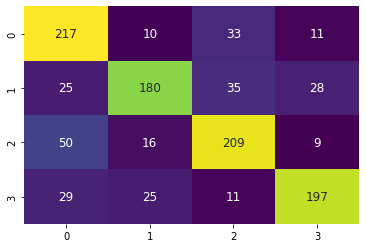

In [66]:
draw_confusion_matrix(y_test, l2reg_pred)

In [67]:
print(classification_report(y_test.argmax(axis=1), l2reg_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.68      0.80      0.73       271
           1       0.78      0.67      0.72       268
           2       0.73      0.74      0.73       284
           3       0.80      0.75      0.78       262

    accuracy                           0.74      1085
   macro avg       0.75      0.74      0.74      1085
weighted avg       0.75      0.74      0.74      1085

